# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [2]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from transformers import ViTFeatureExtractor, ViTForImageClassification

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [3]:
# random seed
SEED = 1 
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [5]:
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [8]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [9]:
##################### Write your answer here ##################
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()
###############################################################

In [21]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [22]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

### Model Training

In [29]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0127 Acc: 0.3945
Begin test......
Test Loss: 0.0122 Acc: 0.4181
Epoch: 2/30 Train Loss: 0.0127 Acc: 0.3952
Begin test......
Test Loss: 0.0122 Acc: 0.4207
Epoch: 3/30 Train Loss: 0.0127 Acc: 0.3933
Begin test......
Test Loss: 0.0122 Acc: 0.4189
Epoch: 4/30 Train Loss: 0.0126 Acc: 0.3956
Begin test......
Test Loss: 0.0123 Acc: 0.4185
Epoch: 5/30 Train Loss: 0.0127 Acc: 0.3954
Begin test......
Test Loss: 0.0122 Acc: 0.4200
Epoch: 6/30 Train Loss: 0.0126 Acc: 0.3956
Begin test......
Test Loss: 0.0122 Acc: 0.4217
Epoch: 7/30 Train Loss: 0.0126 Acc: 0.3959
Begin test......
Test Loss: 0.0122 Acc: 0.4217
Epoch: 8/30 Train Loss: 0.0126 Acc: 0.3962
Begin test......
Test Loss: 0.0122 Acc: 0.4201
Epoch: 9/30 Train Loss: 0.0126 Acc: 0.3951
Begin test......
Test Loss: 0.0122 Acc: 0.4184
Epoch: 10/30 Train Loss: 0.0126 Acc: 0.3962
Begin test......
Test Loss: 0.0122 Acc: 0.4206
Epoch: 11/30 Train Loss: 0.0126 Acc: 0.3943
Begin test......
Test Loss: 0.0122 Acc: 0.4205
Epoch: 1

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [11]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [12]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
input = input.to(device)
output = model(input.unsqueeze(0))
probabilities = torch.softmax(output, dim=1)
predict_label = torch.argmax(probabilities)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


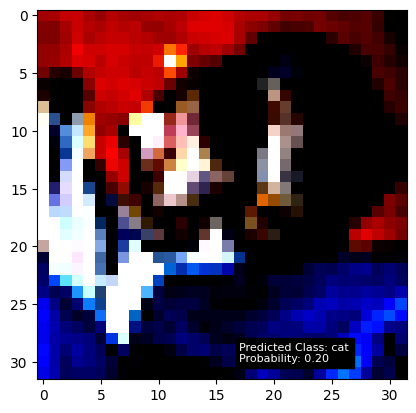

Print probabilities for each class:
airplane: 0.0214
automobile: 0.1870
bird: 0.0504
cat: 0.2001
deer: 0.0367
dog: 0.1293
frog: 0.0418
horse: 0.1058
ship: 0.1853
truck: 0.0423


[None, None, None, None, None, None, None, None, None, None]

In [32]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[0, predict_label].item()

image = input.cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
[print(f'{class_names[i]}: {probabilities[0, i].item():.4f}') for i in range(len(class_names))]

# Test with ViT model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Dataset
import timm
import os
import numpy as np
import matplotlib.pyplot as plt

In [10]:
learning_rate = 1e-03
train_batch_size = 32
eval_batch_size = 32
seed = 42
gradient_accumulation_steps = 4
total_train_batch_size = 128
optimizer = 'Adam'
lr_scheduler_type = 'linear'
lr_scheduler_warmup_ratio = 0.1
num_epochs = 1

l1_weight = 0.01

In [3]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [14]:
resize_size = 224  

transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((resize_size, resize_size)),  
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.Resize((resize_size, resize_size)),  
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_set = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_cifar10_train)
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=2)

test_set = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_cifar10_test)
test_loader = DataLoader(test_set, batch_size=eval_batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [6]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=10)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/root/miniconda3/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [13]:
criterion = nn.CrossEntropyLoss().to(device)

if optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)
else:
    raise ValueError("Optimizer not supported")

if lr_scheduler_type == 'linear':
    num_steps = len(train_loader) * num_epochs
    warmup_steps = int(num_steps * lr_scheduler_warmup_ratio)
    lr_scheduler = optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: min((step + 1) / warmup_steps, 1.0),
    )
else:
    raise ValueError("Learning rate scheduler not supported")

In [8]:
import os
checkpoint_dir = "/root/autodl-tmp/STA303-Assignment01/ViT_checkpoint"
os.makedirs(checkpoint_dir, exist_ok=True)


save_checkpoint_interval = 1  
max_saved_checkpoints = 5  

saved_checkpoints = []

In [15]:
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            l1_regularization = 0.5 * l1_weight * sum(w.abs().sum() for w in model.parameters())
            loss1 = l1_regularization + loss

            _, predicted = outputs.max(1)
            total_correct += predicted.eq(targets).sum().item()
            total_samples += targets.size(0)
            total_loss += loss1.item()
    accuracy = total_correct / total_samples
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

def train(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    total_steps = len(train_loader)
    for epoch in range(num_epochs):
        for step, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            l1_regularization = 0.5 * l1_weight * sum(w.abs().sum() for w in model.parameters())
            loss1 = l1_regularization + loss

            loss1.backward()
            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
            if (step + 1) % 10 == 0:  # 每10个小批次打印一次
                print(f"Training Loss: {loss.item():.4f}\tEpoch: {epoch+1}\tStep: {step+1}")
                # 保存模型检查点
                if (step + 1) % save_checkpoint_interval == 0:
                    checkpoint_path = os.path.join(checkpoint_dir, f'model_checkpoint_epoch{epoch+1}_step{step+1}.pt')
                    torch.save({
                        'epoch': epoch,
                        'step': step,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                    }, checkpoint_path)
                    print(f"Saved checkpoint at {checkpoint_path}")
                    
                    # 将检查点路径添加到列表中
                    saved_checkpoints.append(checkpoint_path)
                    
                    # 检查并删除旧的检查点
                    if len(saved_checkpoints) > max_saved_checkpoints:
                        old_checkpoint = saved_checkpoints.pop(0)
                        os.remove(old_checkpoint)
                        print(f"Removed old checkpoint: {old_checkpoint}")
                if (step + 1) % 100 == 0:  # 每100个小批次打印一次
                    validation_loss, accuracy = evaluate(model, test_loader)
                    print(f"Test Loss: {validation_loss:.4f}\tAccuracy: {100 * accuracy:.2f}%")


In [16]:
# Training
train(model, train_loader, optimizer, criterion, num_epochs)

Training Loss: 2.9320	Epoch: 1	Step: 10
Saved checkpoint at /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step10.pt
Training Loss: 3.4195	Epoch: 1	Step: 20
Saved checkpoint at /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step20.pt
Training Loss: 3.0313	Epoch: 1	Step: 30
Saved checkpoint at /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step30.pt
Training Loss: 2.4472	Epoch: 1	Step: 40
Saved checkpoint at /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step40.pt
Training Loss: 2.2982	Epoch: 1	Step: 50
Saved checkpoint at /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step50.pt
Training Loss: 2.2393	Epoch: 1	Step: 60
Saved checkpoint at /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step60.pt
Removed old checkpoint: /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step10.pt
Training Loss:

In [19]:
checkpoint_path = '/root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step1560.pt'
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
step = checkpoint['step']
loss = checkpoint['loss']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


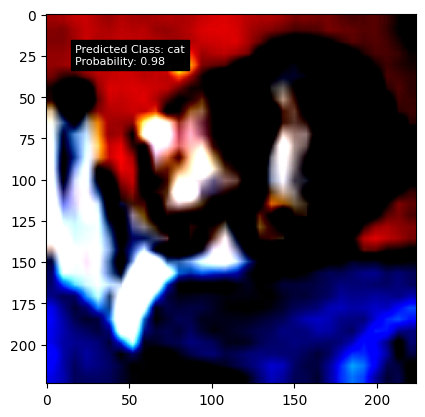

Print probabilities for each class:
airplane: 0.0014
automobile: 0.0058
bird: 0.0003
cat: 0.9809
deer: 0.0014
dog: 0.0035
frog: 0.0050
horse: 0.0004
ship: 0.0006
truck: 0.0006


[None, None, None, None, None, None, None, None, None, None]

In [22]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

inputs, classes = next(iter(test_loader))
input = inputs[0]
input = input.to(device)
output = model(input.unsqueeze(0))
probabilities = torch.softmax(output, dim=1)
predict_label = torch.argmax(probabilities)
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[0, predict_label].item()

image = input.cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
[print(f'{class_names[i]}: {probabilities[0, i].item():.4f}') for i in range(len(class_names))]

# Test with dert-resnet50 model

In [8]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

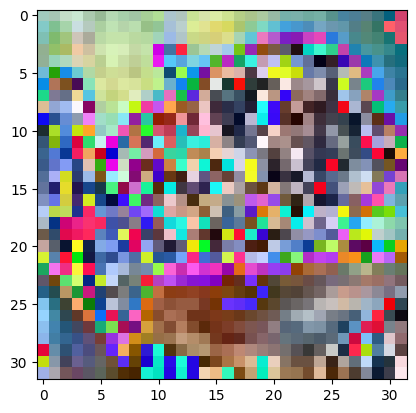

In [9]:
from PIL import Image

inputs, classes = next(iter(test_dataloader))
input = inputs[0]

# Convert tensor to PIL Image
input_image = transforms.ToPILImage()(input)

# Save image as .jpg
input_image.save("test_image.jpg")
plt.imshow(input_image)
image = input_image


In [21]:
# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
resnet = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = resnet(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.6)[0]

In [22]:

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {resnet.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )
print(f"Number of detected objects: {len(results['scores'])}")    

Detected tv with confidence 0.634 at location [-0.01, 0.02, 31.99, 32.02]
Number of detected objects: 1


# Resnet-101

In [23]:
# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-101", revision="no_timm")
resnet = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = resnet(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.6)[0]

C:\Users\Radicalyyy\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Radicalyyy\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [24]:

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {resnet.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )
print(f"Number of detected objects: {len(results['scores'])}")    

Detected tv with confidence 0.995 at location [-0.01, -0.0, 31.99, 32.0]
Number of detected objects: 1
